In [21]:
#import dependencies
import pandas as pd
import json
import geopandas as gpd
import sqlite3
import requests
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
#upload files to colab
from google.colab import files
uploaded = files.upload()

Saving Cville_Real_Estate.csv to Cville_Real_Estate (1).csv


<ipython-input-22-ca435341333e>:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modified_data['Style'] = modified_data['Style'].map(style_mapping)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


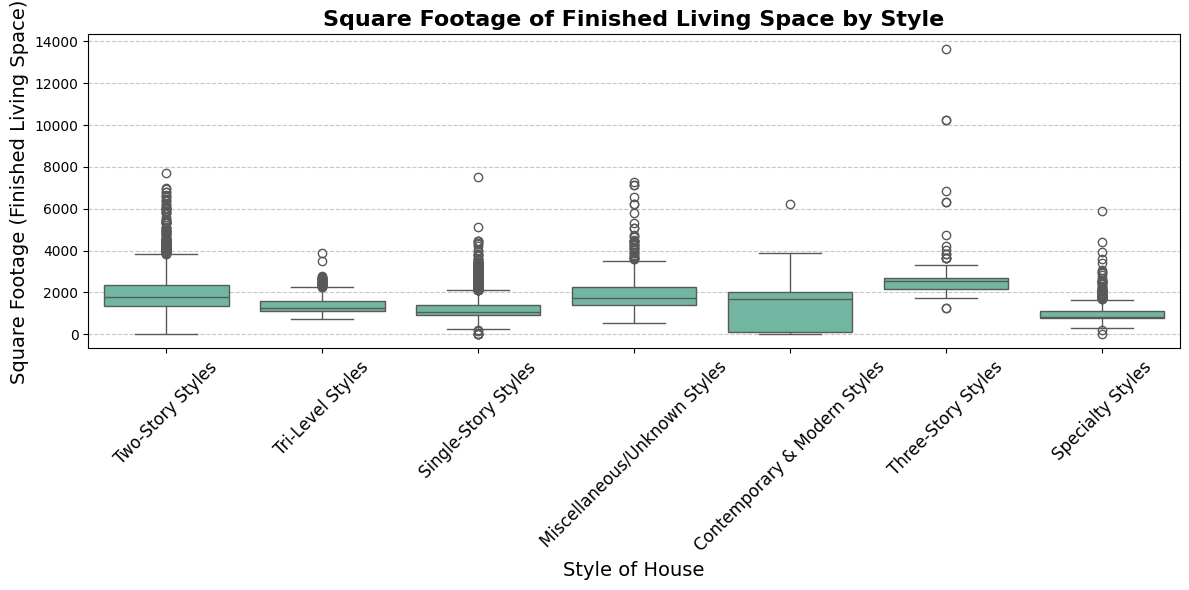

In [22]:
#define the functions for the ETL process

#function to load the csv data from a local file or URL
def load_csv_data(file_path_or_url):
    try:
        if file_path_or_url.startswith('http'):  #check if the input is a URL
            data = pd.read_csv(file_path_or_url)
            print(f"CSV file from URL '{file_path_or_url}' loaded successfully!")
        else:
            data = pd.read_csv(file_path_or_url)
            print(f"CSV file '{file_path_or_url}' loaded successfully!")
        return data
    except Exception as e:
        print(f"Failed to load CSV file: {e}")

#function to load geojson data from a local file or URL
def load_geojson_data(file_path_or_url):
    try:
        if file_path_or_url.startswith('http'):  #check if the input is a URL
            data = gpd.read_file(file_path_or_url)
            print(f"GeoJSON file from URL '{file_path_or_url}' loaded successfully!")
        else:
            data = gpd.read_file(file_path_or_url)
            print(f"GeoJSON file '{file_path_or_url}' loaded successfully!")
        return data
    except Exception as e:
        print(f"Failed to load GeoJSON file: {e}")

#function to convert csv to json
def csv_to_json(csv_file, output_file):
    try:
        data = pd.read_csv(csv_file)
        data.to_json(output_file, orient='records', lines=True)
        print(f"CSV file '{csv_file}' converted to JSON and saved as '{output_file}'!")
    except Exception as e:
        print(f"Error converting CSV to JSON: {e}")

#function to convert geojson to csv
def geojson_to_csv(geojson_file, output_file):
    try:
        data = gpd.read_file(geojson_file)
        data.to_csv(output_file, index=False)
        print(f"GeoJSON file '{geojson_file}' converted to CSV and saved as '{output_file}'!")
    except Exception as e:
        print(f"Error converting GeoJSON to CSV: {e}")

#function to modify columns (add/remove)
def modify_columns(data, columns_to_keep=None, add_columns=None):
    try:
        if columns_to_keep:
            data = data[columns_to_keep]

        if add_columns:
            for col_name, value in add_columns.items():
                data[col_name] = value

        print(f"Columns modified successfully!")
        return data
    except Exception as e:
        print(f"Error modifying columns: {e}")

#function for visualizing square footage by style (creativity aspect)

#create a mapping for grouping styles
style_mapping = {
    '1 Story': 'Single-Story Styles',
    '1 Sty Excellent': 'Single-Story Styles',
    '1 Sty No Bsmt': 'Single-Story Styles',
    '1 Sty w/ Bsmt': 'Single-Story Styles',
    '1 Sty (Avg)': 'Single-Story Styles',
    '1 Sty Attached': 'Single-Story Styles',
    '1 Sty Superior': 'Single-Story Styles',
    '1.5 Sty': 'Single-Story Styles',
    '1.5 Sty Excellent': 'Single-Story Styles',
    '1.5 Sty (Avg)': 'Single-Story Styles',
    '1.5 Sty Attached': 'Single-Story Styles',
    '1.5 Sty Transitional': 'Single-Story Styles',
    '2 Story': 'Two-Story Styles',
    '2 Story w/ Bsmt': 'Two-Story Styles',
    '2 Story (Avg)': 'Two-Story Styles',
    '2 Sty No Bsmt': 'Two-Story Styles',
    '2 Sty Attached': 'Two-Story Styles',
    '2 Sty Excellent': 'Two-Story Styles',
    '2 Sty Superior': 'Two-Story Styles',
    '2 Sty Transitional': 'Two-Story Styles',
    '2 Sty Contemporary': 'Two-Story Styles',
    '2.5 Story': 'Two-Story Styles',
    '2.5 Story (Avg)': 'Two-Story Styles',
    '2.5 Sty Attached': 'Two-Story Styles',
    '2.5 Sty Excellent': 'Two-Story Styles',
    '2.5 Sty Superior': 'Two-Story Styles',
    'Tri-Level': 'Tri-Level Styles',
    'Split-Level': 'Tri-Level Styles',
    'Split-Level Exc': 'Tri-Level Styles',
    'Split-Level (Avg)': 'Tri-Level Styles',
    'Split-Level Superior': 'Tri-Level Styles',
    'Split-Foyer': 'Tri-Level Styles',
    'Split-Foyer Exc': 'Tri-Level Styles',
    'Split-Foyer (Avg)': 'Tri-Level Styles',
    'Split-Foyer Superior': 'Tri-Level Styles',
    '4-Level Split': 'Tri-Level Styles',
    '3 Story': 'Three-Story Styles',
    '3 Sty Excellent': 'Three-Story Styles',
    '3 Sty Attached': 'Three-Story Styles',
    '3.5 Story': 'Three-Story Styles',
    'Contemporary': 'Contemporary & Modern Styles',
    '2 Sty Contemporary': 'Contemporary & Modern Styles',
    'Ranch': 'Contemporary & Modern Styles',
    'No Style': 'Contemporary & Modern Styles',
    'No data': 'Contemporary & Modern Styles',
    'Vacant Land': 'Contemporary & Modern Styles',
    'Condominium': 'Specialty Styles',
    'Farmhouse': 'Specialty Styles',
    'Cottage': 'Specialty Styles',
    'Tudor': 'Specialty Styles',
    'Victorian': 'Specialty Styles',
    '2 Sty Superior': 'Miscellaneous/Unknown Styles',
    '2 Sty Transitional': 'Miscellaneous/Unknown Styles',
    '1.5 Sty Transitional': 'Miscellaneous/Unknown Styles',
    '1.5 Sty Superior': 'Miscellaneous/Unknown Styles',
    '2.5 Sty Transitional': 'Miscellaneous/Unknown Styles',
    '2 Sty (Avg)': 'Miscellaneous/Unknown Styles',
    '2 Sty No Bsmt': 'Miscellaneous/Unknown Styles',
}

#assume modified_data is the dataframe containing the house data
#replace styles in the dataframe using the mapping
modified_data['Style'] = modified_data['Style'].map(style_mapping)

#function for visualizing square footage by style (creativity aspect)
def visualize_square_footage_by_style(data):
    plt.figure(figsize=(12, 6))

    #set a color palette for the box plot
    sns.set_palette("Set2")

    #box plot of square footage by style
    sns.boxplot(data=data, x='Style', y='SquareFootageFinishedLiving')

    #customize the plot
    plt.title('Square Footage of Finished Living Space by Style', fontsize=16, fontweight='bold')
    plt.xlabel('Style of House', fontsize=14)
    plt.ylabel('Square Footage (Finished Living Space)', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)  #rotate x labels for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)  #add horizontal grid lines
    plt.tight_layout()  #adjust layout for better spacing
    plt.show()

#call the visualization function
visualize_square_footage_by_style(modified_data)

#function to store data into SQLite
def store_to_sqlite(data, table_name, db_name="real_estate.db"):
    try:
        conn = sqlite3.connect(db_name)
        data.to_sql(table_name, conn, if_exists='replace', index=False)
        conn.close()
        print(f"Data stored in '{table_name}' table in '{db_name}' database!")
    except Exception as e:
        print(f"Error storing data in SQLite: {e}")

#function to summarize the data (pre/post processing)
def summarize_data(data, process_type="pre-processing"):
    print(f"Summary of {process_type} data:")
    print(f"Number of records: {data.shape[0]}")
    print(f"Number of columns: {data.shape[1]}")

#function to fetch weather data from open-meteo API
def fetch_weather_data():
    try:
        #set the coordinates for Charlottesville, Virginia
        latitude = 38.0293
        longitude = -78.4784

        #open-meteo API endpoint for weather
        weather_url = f"https://api.open-meteo.com/v1/forecast?latitude={latitude}&longitude={longitude}&current_weather=true"
        response = requests.get(weather_url)
        weather_data = response.json()

        if 'current_weather' in weather_data:
            return weather_data['current_weather']
        else:
            print("Weather data not found.")
            return None
    except Exception as e:
        print(f"Failed to fetch weather data: {e}")
        return None

In [23]:
#load the data files from local file or URL
csv_data = load_csv_data('Cville_Real_Estate.csv')
geojson_data = load_geojson_data('Cville_Real_Estate.geojson')

CSV file 'Cville_Real_Estate.csv' loaded successfully!
GeoJSON file 'Cville_Real_Estate.geojson' loaded successfully!


In [24]:
#summarize the original csv data (pre-processing)
summarize_data(csv_data, process_type="pre-processing")

Summary of pre-processing data:
Number of records: 14867
Number of columns: 24


In [25]:
#convert csv to json
csv_to_json('Cville_Real_Estate.csv', 'Cville_Real_Estate.json')

CSV file 'Cville_Real_Estate.csv' converted to JSON and saved as 'Cville_Real_Estate.json'!


In [26]:
#convert geojson to csv
geojson_to_csv('Cville_Real_Estate.geojson', 'Cville_Real_Estate_from_GeoJSON.csv')

GeoJSON file 'Cville_Real_Estate.geojson' converted to CSV and saved as 'Cville_Real_Estate_from_GeoJSON.csv'!


In [27]:
#modify columns: keeping only a few columns and adding a new one
columns_to_keep = [col for col in csv_data.columns if col not in ['Grade', 'Roof', 'Flooring', 'Heating', 'Fireplace', 'ExternalWalls']]
add_columns = {'NewColumn': 'NewData'}
modified_data = modify_columns(csv_data, columns_to_keep, add_columns)

Columns modified successfully!


<ipython-input-22-ca435341333e>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name] = value


In [28]:
#save the modified data to a new csv file
modified_data.to_csv('Cville_Real_Estate_Modified.csv', index=False)
print("Modified data saved to 'Cville_Real_Estate_Modified.csv'.")

Modified data saved to 'Cville_Real_Estate_Modified.csv'.


In [29]:
#summarize the modified data (post-processing)
summarize_data(modified_data, process_type="post-processing")

Summary of post-processing data:
Number of records: 14867
Number of columns: 19


In [30]:
#store modified data into sqlite
store_to_sqlite(modified_data, 'Real_Estate_Data')

Data stored in 'Real_Estate_Data' table in 'real_estate.db' database!


In [31]:
#fetch weather data for Charlottesville, Virginia
weather_data = fetch_weather_data()
if weather_data:
    print("Weather Data:", weather_data)
else:
    print("Weather Data: None")

Weather Data: {'time': '2024-10-09T16:30', 'interval': 900, 'temperature': 19.3, 'windspeed': 7.0, 'winddirection': 249, 'is_day': 1, 'weathercode': 0}
